In [3]:
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch
import pickle
from utils import load_data
# from scipy.sparse import coo_matrix
import seaborn as sns
# import dgl
import tqdm

In [4]:
browsing, search, sku, info = load_data('../dataset/new/')

load browsing done...
load search done...
load sku done...
load info done...


In [6]:
browsing = browsing[browsing['product_action'] != 4]

In [7]:
browsing.dropna(inplace=True)
browsing['product_sku_hash'] = browsing['product_sku_hash'].astype(int)

In [8]:
browsing['next_product_sku_hash']=browsing.groupby('session_id_hash')['product_sku_hash'].shift(-1)

In [9]:
browsing.dropna(inplace=True)
browsing['next_product_sku_hash'] = browsing['next_product_sku_hash'].astype(int)

In [10]:
browsing['next_product_sku_hash'].nunique(), browsing['product_sku_hash'].nunique()

(30025, 29987)

In [11]:
browsing

session_id_hash  product_action  product_sku_hash  \
train 0                     0               0             31231   
      1                     0               0             30494   
      3                     0               0             31231   
      7                     0               0             31231   
      16                    0               0             16827   
...                       ...             ...               ...   
test  559498          5076750               0             28215   
      559499          5076750               0             17692   
      559500          5076750               0             28215   
      559501          5076750               0             17692   
      559512          5076752               0              7109   

              server_timestamp_epoch_ms  hashed_url  next_product_sku_hash  
train 0                   1550885210881           0                  30494  
      1                   1550885213307           1                  31231  
      3                   1550885215484           0                  31231  
      7                   1550885304014           0                  16827  
      16                  1550885885435           9                  18868  
...                                 ...         ...                    ...  
test  559498              1555619228653        5118                  17692  
      559499              1555619233752      490211                  28215  
      559500              1555619239294        5118                  17692  
      559501              1555619241764      490211                   7667  
      559512              1557406412461        7838                  13492  

[6982471 rows x 6 columns]

In [12]:
count_pair = browsing.groupby(['product_sku_hash', 'next_product_sku_hash']).size().reset_index()
count_pair.columns =  ['src_id', 'dst_id', 'weight']

In [15]:
count_pair.to_csv('../dataset/prepared/i-i.txt', index=False, header=False, sep=' ')

In [20]:
len(info.idx2item)

66386

In [21]:
with open('deepwalk/i-i.embed', 'r') as f:
    line = f.readline()
    embedding = torch.zeros(66386, 128)
    for line in tqdm.tqdm(f):
        line = line.split(' ')
        node_id  = int(line[0])
        node_vec = list(map(float, line[1:]))
        embedding[node_id] = torch.tensor(node_vec)

30243it [00:01, 20834.38it/s]


In [25]:
embedding = F.normalize(embedding, dim=1)
with open('../dataset/prepared/dw_sku_i-i.pkl', 'wb') as f:
    pickle.dump(embedding.numpy(), f)

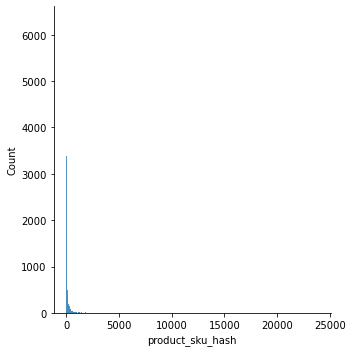

In [29]:
sns.displot(browsing.groupby('product_sku_hash')['product_sku_hash'].count())